In [1]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import utils as pic

%load_ext autoreload
%autoreload 2

In [2]:
lr_init = 1.e-5    # Initial learning rate
batch_size = 100       # Training batch size
train_size = 3000     # Training size
valid_size = 1000     # Validation size
test_size = 1000     # Test size
epochs = 20       # Number of epochs
doGPU = False    # Use GPU
tmin = -0.015    # Minimum time cutoff
tmax = 0.01     # Maximum time cutoff
tstep = 0.001   # Time steps
low_e = 0.005


In [3]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [4]:
X_e_train, X_t_train, maxframes, time_bins = pic.timeordered_BC(X_train, cumulative=True,low_e=low_e, min_t=tmin, max_t=tmax, t_step=tstep )

In [5]:
X_e_valid, X_t_valid, maxframes, time_bins = pic.timeordered_BC(X_valid, cumulative=True,low_e=low_e, min_t=tmin, max_t=tmax, t_step=tstep )

In [6]:
X_e_test, X_t_test, _, _ = pic.timeordered_BC(X_test, cumulative=True,low_e=low_e, min_t=tmin, max_t=tmax, t_step=tstep)

In [7]:
model = keras.Sequential()

model.add(layers.Reshape((maxframes, 32, 32, 1),input_shape=(maxframes, 32, 32)))
model.add(layers.ConvLSTM2D(32, 3, padding='same', return_sequences=True))
model.add(layers.ReLU())
model.add(layers.ConvLSTM2D(16, 3, padding='same'))
model.add(layers.ReLU())
model.add(layers.Conv2D(16,3,padding='same'))
model.add(layers.ReLU())
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(25))
model.add(layers.ReLU())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 25, 32, 32, 1)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 25, 32, 32, 32)    38144     
_________________________________________________________________
re_lu (ReLU)                 (None, 25, 32, 32, 32)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 32, 32, 16)        27712     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        2320      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 32, 32, 16)        0

In [8]:
import gc
import tensorflow as tf
class CleanGarbage(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

In [11]:
model.compile(loss='binary_crossentropy', optimizer='nadam',metrics=['accuracy'])

In [12]:
history = model.fit(
    X_e_train, y_train,
    validation_data=(X_e_valid,y_valid),
    epochs=5,
    batch_size=50,
    shuffle=True,
    callbacks=[CleanGarbage()],
    verbose=1
)

Epoch 1/5
120/120 [==============================] - 486s 4s/step - loss: 0.6620 - accuracy: 0.6138 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/5
120/120 [==============================] - 503s 4s/step - loss: 0.6580 - accuracy: 0.6165 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 3/5
  4/120 [>.............................] - ETA: 7:30 - loss: 0.6559 - accuracy: 0.6450

KeyboardInterrupt: 

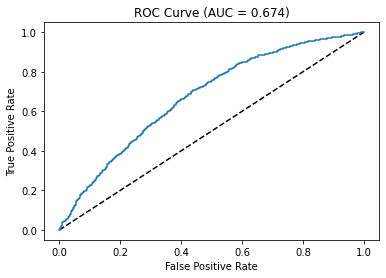

In [13]:
%matplotlib inline
pic.plot_roc(y_test, model.predict(X_e_test))

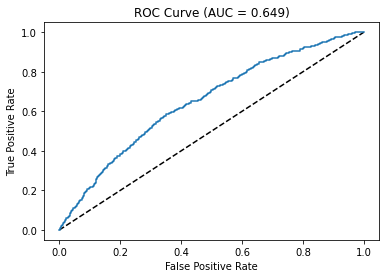

In [ ]:
%matplotlib inline
pic.plot_roc(y_valid, model.predict(X_e_valid))

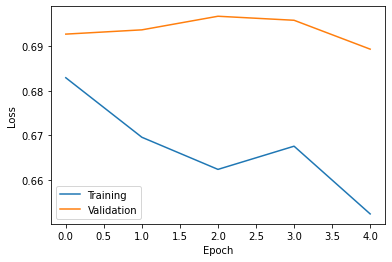

In [ ]:
metric = 'loss'
loss = history.history[metric]
val_loss = history.history[f'val_{metric}']

plt.plot(loss,label='Training')
plt.plot(val_loss,label='Validation')
plt.xlabel('Epoch')
plt.ylabel(metric.capitalize())
plt.legend()
plt.show()